# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
## Εργασία 1: Επιβλεπόμενη Μάθηση - Ταξινόμηση
### Ομάδα 44
* Βασιλάκος Μιχαήλ <br>
Α.Μ.: 03117069
* Γαβαλάς Παντελεήμων <br>
Α.Μ.: 03117075

In [ ]:
# import used modules
!pip install --upgrade imbalanced-learn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Μέρος 1: UCI dataset
Το dataset του UCI Machine Learning Repository που αντιστοιχεί στην ομάδα μας είναι το [HCC Survival Data Set](https://archive.ics.uci.edu/ml/datasets/HCC+Survival). Το συγκεκριμένο dataset περιέχει πληροφορίες σχετικά με την επιβίωση ασθενών με Ηπατοκυτταρικό καρκίνωμα (HCC) σε διάστημα ενός χρόνου από τη συλλογή των στοιχείων που δίνονται στο dataset. Δίνονται 49 features, 23 εκ των οποίων είναι κατηγορικά ενώ τα υπόλοιπα 26 είναι διατεταγμένα.

### Εισαγωγή και επισκόπηση δεδομένων

Αρχικά φορτώνουμε το dataset στο notebook και ελέγχουμε τα πρώτα στοιχεία του καθώς και τις διαστάσεις του.

In [ ]:
# read dataset
df = pd.read_csv("hcc-data.txt", header=None, na_values=["?"])
print(df.head(), df.shape)

   0    1   2    3    4    5    6   ...   43    44   45    46    47    48  49
0   1  0.0   1  0.0  0.0  0.0  0.0  ...  1.0   3.5  0.5   NaN   NaN   NaN   1
1   0  NaN   0  0.0  0.0  0.0  1.0  ...  1.0   1.8  NaN   NaN   NaN   NaN   1
2   1  0.0   1  1.0  0.0  1.0  0.0  ...  5.0  13.0  0.1  28.0   6.0  16.0   1
3   1  1.0   1  0.0  0.0  0.0  0.0  ...  2.0  15.7  0.2   NaN   NaN   NaN   0
4   1  1.0   1  1.0  0.0  1.0  0.0  ...  1.0   9.0  NaN  59.0  15.0  22.0   1

[5 rows x 50 columns] (165, 50)


Το αρχείο text δεν χρειάστηκε κάποια μετατροπή για να εισαχθεί στο notebook. Βλέπουμε πως υπάρχουν 50 στήλες στο dataframe, το οποίο σημαίνει πως έχουμε 49 χαρακτηριστικά και 1 ετικέτα. Από την περιγραφή των χαρακτηριστικών στο UCI Repository βλέπουμε πως τα πρώτα 23 χαρακτηριστικά είναι μη διατεταγμένα (κατηγορικά) και είναι:
* Gender (1: Άνδρας; 0: Γυναίκα)
* Symptoms (1: Ναι; 0: Όχι)
* Alcohol (1: Ναι; 0: Όχι)
* Hepatitis B Surface Antigen (1: Ναι; 0: Όχι)
* Hepatitis B e Antigen (1: Ναι; 0: Όχι)
* Hepatitis B Core Antibody (1: Ναι; 0: Όχι)
* Hepatitis C Virus Antibody (1: Ναι; 0: Όχι)
* Cirrhosis (1: Ναι; 0: Όχι)
* Endemic Countries (1: Ναι; 0: Όχι)
* Smoking (1: Ναι; 0: Όχι)
* Diabetes (1: Ναι; 0: Όχι)
* Obesity (1: Ναι; 0: Όχι)
* Hemochromatosis (1: Ναι; 0: Όχι)
* Arterial Hypertension (1: Ναι; 0: Όχι)
* Chronic Renal Insufficiency (1: Ναι; 0: Όχι)
* Human Immunodeficiency Virus (1: Ναι; 0: Όχι)
* Nonalcoholic Steatohepatitis (1: Ναι; 0: Όχι)
* Esophageal Varices (1: Ναι; 0: Όχι)
* Splenomegaly (1: Ναι; 0: Όχι)
* Portal Hypertension (1: Ναι; 0: Όχι)
* Portal Vein Thrombosis (1: Ναι; 0: Όχι)
* Liver Metastasis (1: Ναι; 0: Όχι)
* Radiological Hallmark  (1: Ναι; 0: Όχι)

Το dataset δεν περιέχει επικεφαλίδες ούτε αρίθμηση σειρών. Οι ετικέτες των κλάσεων είναι στην 50η στήλη και λαμβάνουν τιμές 1 και 0, όπου το 1 εκφράζει την επιβίωση του ασθενή στον 1 χρόνο ενώ το 0 το αντίθετο.

In [ ]:
# find missing values
print("Total missing values:", df.isnull().sum(axis=1).sum())
# find samples with missing values
missing_samples = df.isnull().any(axis=1).sum()
print("Number of samples with missing values: {} which represents {:.2f}% \
of total samples".format(missing_samples, missing_samples/df.shape[0]*100))
# find features with missing values
missing_cols = df.isnull().sum(axis=0)
missing_cols_percent = ["{:.1f}%".format(x/df.shape[0]*100) for x in missing_cols]
print("Percentage of samples with missing features:")
for i in range(len(missing_cols_percent)-1):
  print("Feature {}: {}".format(i, missing_cols_percent[i]))

Total missing values: 826
Number of samples with missing values: 157 which represents 95.15% of total samples
Percentage of samples with missing features:
Feature 0: 0.0%
Feature 1: 10.9%
Feature 2: 0.0%
Feature 3: 10.3%
Feature 4: 23.6%
Feature 5: 14.5%
Feature 6: 5.5%
Feature 7: 0.0%
Feature 8: 23.6%
Feature 9: 24.8%
Feature 10: 1.8%
Feature 11: 6.1%
Feature 12: 13.9%
Feature 13: 1.8%
Feature 14: 1.2%
Feature 15: 8.5%
Feature 16: 13.3%
Feature 17: 31.5%
Feature 18: 9.1%
Feature 19: 6.7%
Feature 20: 1.8%
Feature 21: 2.4%
Feature 22: 1.2%
Feature 23: 0.0%
Feature 24: 29.1%
Feature 25: 32.1%
Feature 26: 0.0%
Feature 27: 0.6%
Feature 28: 1.2%
Feature 29: 2.4%
Feature 30: 4.8%
Feature 31: 1.8%
Feature 32: 1.8%
Feature 33: 1.8%
Feature 34: 1.8%
Feature 35: 3.6%
Feature 36: 3.0%
Feature 37: 2.4%
Feature 38: 1.8%
Feature 39: 1.8%
Feature 40: 1.8%
Feature 41: 6.7%
Feature 42: 4.2%
Feature 43: 1.2%
Feature 44: 12.1%
Feature 45: 26.7%
Feature 46: 47.9%
Feature 47: 48.5%
Feature 48: 48.5%


Παρατηρούμε πως μας λείπουν 826 τιμές συνολικά. Δεδομένου ότι έχουμε 49 χαρακτηριστικά και 165 δείγματα μας λείπουν $\frac{826}{49*165}*100\% = 10.2\%$ των τιμών του dataset. Επιπλέον, είδαμε πως πάνω από το 95% των δειγμάτων έχουν τουλάχιστον μία τιμή που απουσιάζει, οπότε δεν είναι δυνατή η αφαίρεση των δειγμάτων των οποίων οι τιμές απουσιάζουν. Επίσης είδαμε πως 7 από τα 49 χαρακτηριστικά απουσιάζουν για πάνω από το 25% των δειγμάτων, ενώ 3 εξ αυτών απουσιάζουν για περίπου τα μισά δείγματα.

In [ ]:
# count instances of each class
class1 = df.iloc[:,49].sum()
class0 = df.shape[0] - class1
print("Class 0 has {} samples which represents {:.1f}% of all samples".format
      (class0, class0/df.shape[0]*100))
print("Class 1 has {} samples which represents {:.1f}% of all samples".format
      (class1, class1/df.shape[0]*100))

Class 0 has 63 samples which represents 38.2% of all samples
Class 1 has 102 samples which represents 61.8% of all samples


Παρατηρούμε πως η κλάση 1 (ο ασθενής ζει) αντιπροσωπεύει το 61.8% των δειγμάτων του dataset, έναντι του 38.2% που αντιστοιχεί στην κλάση 0 (ο ασθενής πεθαίνει). Αυτό σημαίνει πως το dataset δεν είναι ισορροπημένο και συνεπώς απαιτείται ειδικός χειρισμός για την αποτελεσματικότερη χρήση του.

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67,137.0,15.0,0,1.0,1.0,1.53,95.0,13.7,106.6,4.9,99.0,3.4,2.1,34.0,41.0,183.0,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,62,0.0,NaN,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,78,50.0,50.0,2,1.0,2.0,0.96,5.8,8.9,79.8,8.4,472.0,3.3,0.4,58.0,68.0,202.0,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,77,40.0,30.0,0,1.0,1.0,0.95,2440.0,13.4,97.1,9.0,279.0,3.7,0.4,16.0,64.0,94.0,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,76,100.0,30.0,0,1.0,1.0,0.94,49.0,14.3,95.1,6.4,199.0,4.1,0.7,147.0,306.0,173.0,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


### Προετοιμασία δεδομένων

Χωρίζουμε το dataset σε δύο μέρη ώστε να δημιουργήσουμε τα train και test sets με το test set να αποτελεί το 30% των δειγμάτων.

In [ ]:
# differentiate labels from features
X_df = df.iloc[:,:49].copy()
y_df = df.iloc[:,49].copy()

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.3)

Επειδή όπως δείξαμε παραπάνω στα features 46, 47 και 48 λείπουν οι τιμές για περίπου τα μισά δείγματα, η συμπλήρωσή τους δεν αποτελεί καλή πρακτική και για τον λόγο αυτό τα αφαιρούμε από τα δεδομένα μας.

In [ ]:
X_train.drop([46, 47, 48], axis=1, inplace=True)
X_test.drop([46, 47, 48], axis=1, inplace=True)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
102,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,64,70.0,NaN,2,1.0,2.0,1.55,5.7,13.9,99.7,5200.0,124000.0,2.1,0.8,37.0,75.0,203.0,110.0,5.0,0.56,3.0,2.4,NaN
60,1,1.0,0,1.0,0.0,1.0,0.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,76,0.0,50.0,1,1.0,3.0,1.28,608.0,12.6,100.0,5.4,129.0,4.0,1.7,107.0,99.0,125.0,100.0,7.5,0.90,5.0,3.5,0.5
31,1,0.0,1,0.0,NaN,0.0,0.0,1,NaN,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,62,120.0,NaN,0,1.0,1.0,1.44,1237.0,12.2,94.0,6200.0,93000.0,4.2,1.0,35.0,85.0,191.0,129.0,58.0,1.06,5.0,7.0,NaN
37,1,1.0,1,0.0,0.0,0.0,0.0,1,NaN,1.0,1.0,0.0,NaN,1.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,84,200.0,30.0,1,1.0,2.0,1.24,633.0,13.0,96.5,7200.0,143000.0,2.3,1.1,40.0,58.0,322.0,209.0,6.7,1.40,5.0,4.9,0.2
33,1,1.0,1,0.0,NaN,0.0,0.0,1,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,77,NaN,NaN,0,1.0,1.0,1.24,266.0,13.7,97.7,13000.0,170000.0,4.2,0.5,68.0,85.0,232.0,227.0,16.8,1.72,1.0,5.9,NaN


Εφόσον τα features 0-22 είναι categorical επιλέγουμε να τα συμπληρώσουμε με τις πιο συχνές τιμές για κάθε feature στο training set, ενώ την ίδια τιμή συμπληρώνουμε και στο test set, αφού όποια αλλαγή κάνουμε στα δεδομένα μας πρέπει να γίνεται με βάση την επεξεργασία μόνο των δεδομένων στο training set.

Για τα υπόλοιπα features θα αντικαταστήσουμε τον μέσο όρο των τιμών στο training set.

In [ ]:
imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")

In [ ]:
X_train.iloc[:,:23] = imp_freq.fit_transform(X_train.iloc[:,:23])
X_train.iloc[:,23:] = imp_mean.fit_transform(X_train.iloc[:,23:])

Επιβεβαιώνουμε πως δεν υπάρχουν πλέον κενά πεδία στο training set.

In [ ]:
X_train.isnull().any().any()

False

Τα κατηγορικά δεδομένα δεν χρειάζεται να τα τροποποιήσουμε με κάποια τεχνική (π.χ. one-hot encoding) διότι ήδη βρίσκονται σε μορφή Ναι-Όχι (με το 1 να αναπαριστά το "Ναι" και το 0 το "Όχι").

Επαναλαμβάνουμε με τα δεδομένα του test set χρησιμοποιόντας πληροφορία αποκλειστικά από τα δεδομένα του training set ώστε να μην έχουμε απουσιάζουσες τιμές.

In [ ]:
X_test.iloc[:,:23] = imp_freq.transform(X_test.iloc[:,:23])
X_test.iloc[:,23:] = imp_mean.transform(X_test.iloc[:,23:])

Ελέγχουμε ξανά για κενά πεδία.

In [ ]:
X_test.isnull().any().any()

False

### Ταξινόμηση
Οι ταξινομητές που θα μελετηθούν είναι οι:
* dummy
* Gaussian Naive Bayes (GNB)
* KNearestNeighbors (kNN)
* Logistic Regression (LR)

Οι μετρικές αξιολόγησης που θα χρησιμοποιηθούν είναι οι:
* Ορθότητα (accuracy)
* F1-score

Για όλα τα πειράματα θα χρησιμοποιήσουμε 10-fold cross-validation.

#### Επίδοση out-of-the-box
Για να έχουμε μία βάση σύγκρισης θα εκτελέσουμε αρχικά το πείραμα αφήνοντας τις υπερπαραμέτρους των ταξινομητών στις default τιμές τους.

Αρχικά ορίζουμε τους ταξινομητές.

In [ ]:
dummy_stratified = DummyClassifier(strategy="stratified")
dummy_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_uniform = DummyClassifier(strategy="uniform")
dummy_const_0 = DummyClassifier(strategy="constant", constant=0)
dummy_const_1 = DummyClassifier(strategy="constant", constant=1)

gnb = GaussianNB()
knn = KNeighborsClassifier()
lr = LogisticRegression()

Στη συνέχεια εκπαιδεύουμε τους ταξινομητές και συγκρίνουμε τα αποτελέσματά τους.

In [ ]:
ootb_accuracy = {}

dummy_stratified.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (stratified)"] = accuracy_score(y_test, dummy_stratified.predict(X_test))
dummy_most_frequent.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (most frequent)"] = accuracy_score(y_test, dummy_most_frequent.predict(X_test))
dummy_uniform.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (uniform)"] = accuracy_score(y_test, dummy_uniform.predict(X_test))
dummy_const_0.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (constant 0)"] = accuracy_score(y_test, dummy_const_0.predict(X_test))
dummy_const_1.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (constant 1)"] = accuracy_score(y_test, dummy_const_1.predict(X_test))

gnb.fit(X_train, y_train)
ootb_accuracy["Gaussian Naive-Bayes"] = accuracy_score(y_test, gnb.predict(X_test))
knn.fit(X_train, y_train)
ootb_accuracy["K Nearest Neighbors"] = accuracy_score(y_test, knn.predict(X_test))
lr.fit(X_train, y_train)
ootb_accuracy["Logistic Regression"] = accuracy_score(y_test, lr.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Παρατηρούμε πως ο ταξινομητής logistic regression δεν συγκλίνει κατά την εκπαίδευσή του στην out-of-the-box έκδοσή του.

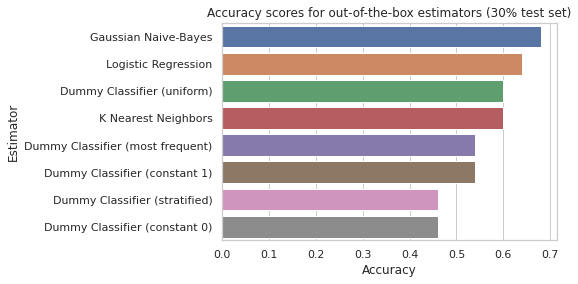

In [ ]:
sorted_accuracy = [(k, ootb_accuracy[k]) for k in sorted(ootb_accuracy, key=ootb_accuracy.get, reverse=True)]
acc_df = pd.DataFrame.from_dict(sorted_accuracy)

sns.set_theme(style="whitegrid")
sns.barplot(y=acc_df.iloc[:,0], x=acc_df.iloc[:,1], data=acc_df)
plt.xlabel("Accuracy")
plt.ylabel("Estimator")
plt.title("Accuracy scores for out-of-the-box estimators (30% test set)")
plt.show()

In [ ]:
ootb_f1 = {}

dummy_stratified.fit(X_train, y_train)
ootb_f1["Dummy Classifier (stratified)"] = f1_score(y_test, dummy_stratified.predict(X_test))
dummy_most_frequent.fit(X_train, y_train)
ootb_f1["Dummy Classifier (most frequent)"] = f1_score(y_test, dummy_most_frequent.predict(X_test))
dummy_uniform.fit(X_train, y_train)
ootb_f1["Dummy Classifier (uniform)"] = f1_score(y_test, dummy_uniform.predict(X_test))
dummy_const_0.fit(X_train, y_train)
ootb_f1["Dummy Classifier (constant 0)"] = f1_score(y_test, dummy_const_0.predict(X_test))
dummy_const_1.fit(X_train, y_train)
ootb_f1["Dummy Classifier (constant 1)"] = f1_score(y_test, dummy_const_1.predict(X_test))

gnb.fit(X_train, y_train)
ootb_f1["Gaussian Naive-Bayes"] = f1_score(y_test, gnb.predict(X_test))
knn.fit(X_train, y_train)
ootb_f1["K Nearest Neighbors"] = f1_score(y_test, knn.predict(X_test))
lr.fit(X_train, y_train)
ootb_f1["Logistic Regression"] = f1_score(y_test, lr.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Ξανά, ο logistic regression δεν καταφέρει να συγκλίνει στην εκπαίδευσή του.

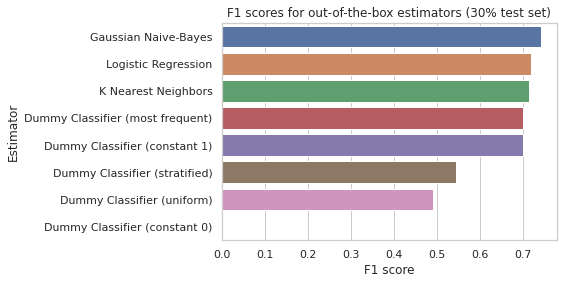

In [ ]:
sorted_f1 = [(k, ootb_f1[k]) for k in sorted(ootb_f1, key=ootb_f1.get, reverse=True)]
f1_df = pd.DataFrame.from_dict(sorted_f1)

sns.set_theme(style="whitegrid")
sns.barplot(y=f1_df.iloc[:,0], x=f1_df.iloc[:,1], data=f1_df)
plt.xlabel("F1 score")
plt.ylabel("Estimator")
plt.title("F1 scores for out-of-the-box estimators (30% test set)")
plt.show()

In [ ]:
print(ootb_accuracy)
print(ootb_f1)

{'Dummy Classifier (stratified)': 0.46, 'Dummy Classifier (most frequent)': 0.54, 'Dummy Classifier (uniform)': 0.6, 'Dummy Classifier (constant 0)': 0.46, 'Dummy Classifier (constant 1)': 0.54, 'Gaussian Naive-Bayes': 0.68, 'K Nearest Neighbors': 0.6, 'Logistic Regression': 0.64}
{'Dummy Classifier (stratified)': 0.5454545454545454, 'Dummy Classifier (most frequent)': 0.7012987012987013, 'Dummy Classifier (uniform)': 0.49056603773584906, 'Dummy Classifier (constant 0)': 0.0, 'Dummy Classifier (constant 1)': 0.7012987012987013, 'Gaussian Naive-Bayes': 0.7419354838709677, 'K Nearest Neighbors': 0.7142857142857142, 'Logistic Regression': 0.7187499999999999}


|       Classifier      | Accuracy | F1 score |
|:---------------------:|:--------:|:--------:|
| Dummy (most frequent) |   0.54   |   0.70   |
|   Dummy (constant 1)  |   0.54   |   0.70   |
|   Dummy (stratified)  |   0.46   |   0.55   |
|    Dummy (uniform)    |   0.60   |   0.49   |
|   Dummy (constant 0)  |   0.46   |   0.00   |
|  Logistic Regression  |   0.64   |   0.74   |
|  Gaussian Naive-Bayes |   0.68   |   0.74   |
|  K Nearest Neighbors  |   0.60   |   0.71   |

Παρατηρούμε πως οι ταξινομητές δεν έχουν ιδιαίτερα καλή επίδοση, καθώς οι dummy ταξινομητές uniform και most frequent έχουν αρκετά υψηλές επιδόσεις, συγκρίσιμες με αυτές των ταξινομητών που μελετάμε. Οι καλές επιδόσεις των dummy ταξινομητών οφείλονται στο έντονο class imbalance που εμφανίζεται στο dataset.

Από τους ταξινομητές, εξαιρώντας τους dummy, τις καλύτερες επιδόσεις και στις δύο μετρικές έχει ο Gaussian Naive-Bayes, ενώ αυτός με τις χειρότερες επιδόσεις είναι ο K Nearest Neighbors. 

#### Βελτιστοποίηση

Σκοπός αυτής της ενότητας είναι η βελτίωση της επίδοσης των ταξινομητών με χρήση των διαδικασιών προεπεξεργασίας, ορισμού pipelines και εύρεσης βέλτιστων υπερπαραμέτρων με grid search με cross validation.

Στο στάδιο της προεπεξεργασίας έχουμε να αντιμετωπίσουμε τα προβλήματα της υψηλής διαστατικότητας, των outliers και του class imbalance. 
* Ξεκινώντας από το πρώτο, μπορούμε να μειώσουμε τις διαστάσεις των δεδομένων μας αρχικά ορίζοντας κάποιο threshold του variance κάθε χαρακτηριστικού, καθώς χαρακτηριστικά με μικρό variance συνήθως δεν συμβάλλουν σημαντικά στην ταξινόμηση. Επιπλέον, με εξαγωγή κύριων συνιστωσών (PCA) μπορούμε να μειώσουμε ακόμα περισσότερο το πλήθος των χαρακτηριστικών.
* Βελτίωση των επιδόσεων των συστημάτων ταξινόμησης μπορούμε να επιτύχουμε και μέσω της κανονικοποίησης των τιμών των χαρακτηριστικών.
* Τέλος, το πρόβλημα του class imbalance μπορεί να βελτιωθεί μέσω του oversampling (αποφεύγουμε το undersampling λόγω των λίγων δειγμάτων του dataset).

Στο επόμενο στάδιο ορίζουμε pipelines από τα οποία περνάνε τα δεδομένα για να εισέλθουν στους ταξινομητές και στα οποία εκτελούμε τις εργασίες που αναφέραμε παραπάνω στο στάδιο προεπεξεργασίας.

Τέλος, με χρήση του grid search cross validation επιλέγουμε τις καλύτερες τιμές για τις υπερπαραμέτρους του pipeline. 

##### F1 score
Αρχικά θα αξιολογήσουμε την επίδοση των μοντέλων με τη μετρική f1.

Αρχικά, εκτελούμε τη διαδικασία βελτιστοποίησης στον ταξινομητή kNN, όπου και ελέγχουμε ένα πλήθος τιμών για τις παραμέτρους threshold του VarianceThreshold(), n_neighbors του KNeighborsClassifier() και n_components του PCA().<br>
Επιπλέον, δοκιμάσαμε να κάνουμε χρήση των μετασχηματιστών MinMaxScaler() και StandardScaler() και βρήκαμε πως με τον πρώτο επιτυγχάνουμε καλύτερα αποτελέσματα στο training set.<br>
Τέλος, δοκιμάσαμε να αφαιρέσουμε βήματα από το pipeline, όμως η επίδοση του ταξινομητή στο training set μειωνόταν.

In [ ]:
vthreshold = [0, 0.01, 0.1, 1, 10]
k = [1, 5, 10, 20, 25, 30, 35, 50]
n_components = [2, 4, 5, 7, 10]

scaler_knn = MinMaxScaler()
selector_knn = VarianceThreshold()
ros_knn = RandomOverSampler()
pca_knn = PCA()
knn = KNeighborsClassifier()

pipe_knn = Pipeline(
    steps=[
           ('selector', selector_knn),
           ('scaler', scaler_knn),
           ('sampler', ros_knn),
           ('pca', pca_knn),
           ('knn', knn)
           ], 
    memory='tmp')
estimator_knn_f1 = GridSearchCV(pipe_knn, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  knn__n_neighbors=k,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='f1', 
                             n_jobs=-1)

start_time = time.time()
estimator_knn_f1.fit(X_train, y_train)
preds_knn = estimator_knn_f1.predict(X_test)
print("Συνολικός χρόνος fit και predict για kNN με μετρική f1 score: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_knn_f1.best_params_)
print("Το καλύτερο f1 score του ταξινομητή ήταν {:.3f} στο training set".format(estimator_knn_f1.best_score_))

Συνολικός χρόνος fit και predict για kNN με μετρική f1 score: 31.12 seconds
Βέλτιστες παράμετροι: {'knn__n_neighbors': 50, 'pca__n_components': 7, 'selector__threshold': 1}
Το καλύτερο f1 score του ταξινομητή ήταν 0.795 στο training set


Επαναλαμβάνουμε την ίδια διαδικασία για τον ταξινομητή GNB με τη διαφορά πως αντί να μεταβάλλουμε την τιμή n_neighbors αλλάζουμε την τιμή της υπερπαραμέτρου var_smoothing του GaussianNB().<br>
Όμοια με πριν δοκιμάσαμε τόσο τον MinMaxScaler() όσο και τον StandardScaler() και με τον δεύτερο πετύχαμε καλύτερα αποτελέσματα, ενώ επίσης δοκιμάσαμε να αφαιρέσουμε βήματα από το pipeline χωρίς να βελτιώσουμε την επίδοση του ταξινομητή στο training set.

In [ ]:
vthreshold = [0, 0.01, 0.1, 1, 10]
var_smoothing = [0, 1e-13, 1e-11, 1e-9, 1e-8]
n_components = [2, 4, 5, 7, 10]

scaler_gnb = StandardScaler()
selector_gnb = VarianceThreshold()
ros_gnb = RandomOverSampler()
pca_gnb = PCA()
gnb = GaussianNB()

pipe_gnb = Pipeline(
    steps=[
           ('selector', selector_gnb),
           ('scaler', scaler_gnb),
           ('sampler', ros_gnb),
           ('pca', pca_gnb),
           ('gnb', gnb)
           ], 
    memory='tmp')
estimator_gnb_f1 = GridSearchCV(pipe_gnb, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  gnb__var_smoothing=var_smoothing,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='f1', 
                             n_jobs=-1)

start_time = time.time()
estimator_gnb_f1.fit(X_train, y_train)
preds_gnb = estimator_gnb_f1.predict(X_test)
print("Συνολικός χρόνος fit και predict για GNB με μετρική f1 score: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_gnb_f1.best_params_)
print("Το καλύτερο f1 score του ταξινομητή ήταν {:.3f} στο training set".format(estimator_gnb_f1.best_score_))

Συνολικός χρόνος fit και predict για GNB με μετρική f1 score: 17.78 seconds
Βέλτιστες παράμετροι: {'gnb__var_smoothing': 0, 'pca__n_components': 2, 'selector__threshold': 0.01}
Το καλύτερο f1 score του ταξινομητή ήταν 0.792 στο training set


Τέλος, επαναλαμβάνουμε για τον LR ψάχνοντας για τις καλύτερες τιμές στις υπερπαραμέτρους pen, tol, C, fit_intercept και max_iter του LogisticRegressor().<br>
Ο scaler με την καλύτερη επίδοση εδώ είναι ο StandardScaler(), ενώ πάλι δεν είδαμε βελτίωση με την αφαίρεση βημάτων από το pipeline.

In [ ]:
vthreshold = [0, 0.1, 1]
n_components = [2, 5, 7, 10]
pen = ['l1', 'l2']
tol = [1e-8, 1e-6, 1e-4, 1e-3]
C = [0.5, 1.0, 1.5, 2.0, 2.5]
fit_intercept = [True, False]
max_iter = [50, 100, 200]

scaler_lr = StandardScaler()
selector_lr = VarianceThreshold()
ros_lr = RandomOverSampler()
pca_lr = PCA()
lr = LogisticRegression()

pipe_lr = Pipeline(
    steps=[
           ('selector', selector_lr),
           ('scaler', scaler_lr),
           ('sampler', ros_lr),
           ('pca', pca_lr),
           ('lr', lr)
           ], 
    memory='tmp')
estimator_lr_f1 = GridSearchCV(pipe_lr, 
                             dict(
                                  selector__threshold=vthreshold,
                                  pca__n_components=n_components,
                                  lr__penalty=pen,
                                  lr__tol=tol,
                                  lr__C=C,
                                  lr__fit_intercept=fit_intercept,
                                  lr__max_iter=max_iter,
                                  lr__solver=['liblinear']
                                  ), 
                             cv=10, 
                             scoring='f1', 
                             n_jobs=-1)

start_time = time.time()
estimator_lr_f1.fit(X_train, y_train)
preds_lr = estimator_lr_f1.predict(X_test)
print("Συνολικός χρόνος fit και predict για LR με μετρική f1 score: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_lr_f1.best_params_)
print("Το καλύτερο f1 score του ταξινομητή ήταν {:.3f} στο training set".format(estimator_lr_f1.best_score_))

Συνολικός χρόνος fit και predict για LR με μετρική f1 score: 428.07 seconds
Βέλτιστες παράμετροι: {'lr__C': 0.5, 'lr__fit_intercept': True, 'lr__max_iter': 50, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'lr__tol': 1e-08, 'pca__n_components': 10, 'selector__threshold': 0.1}
Το καλύτερο f1 score του ταξινομητή ήταν 0.770 στο training set


Εκπαιδεύουμε για κάθε ταξινομητή το μοντέλο με τις καλύτερες επιδόσεις σε ολόκληρο το training set και υπολογίζουμε το f1 score του στο test set ώστε να το συγκρίνουμε με το αντίστοιχο out-of-the-box μοντέλο. 

In [ ]:
knn_best_f1 = estimator_knn_f1.best_estimator_
gnb_best_f1 = estimator_gnb_f1.best_estimator_
lr_best_f1 = estimator_lr_f1.best_estimator_

start_train_time_knn = time.time()
knn_best_f1.fit(X_train, y_train)
train_time_knn = time.time() - start_train_time_knn
start_test_time_knn = time.time()
knn_f1 = f1_score(y_test, knn_best_f1.predict(X_test))
test_time_knn = time.time() - start_test_time_knn

start_train_time_gnb = time.time()
gnb_best_f1.fit(X_train, y_train)
train_time_gnb = time.time() - start_train_time_gnb
start_test_time_gnb = time.time()
gnb_f1 = f1_score(y_test, gnb_best_f1.predict(X_test))
test_time_gnb = time.time() - start_test_time_gnb

start_train_time_lr = time.time()
lr_best_f1.fit(X_train, y_train)
train_time_lr = time.time() - start_train_time_lr
start_test_time_lr = time.time()
lr_f1 = f1_score(y_test, lr_best_f1.predict(X_test))
test_time_lr = time.time() - start_test_time_lr

optimized_f1 = {}
optimized_f1["K Nearest Neighbors"] = knn_f1
optimized_f1["Gaussian Naive-Bayes"] = gnb_f1
optimized_f1["Logistic Regression"] = lr_f1

baseline_f1 = {}
baseline_f1["K Nearest Neighbors"] = ootb_f1["K Nearest Neighbors"]
baseline_f1["Gaussian Naive-Bayes"] = ootb_f1["Gaussian Naive-Bayes"]
baseline_f1["Logistic Regression"] = ootb_f1["Logistic Regression"]

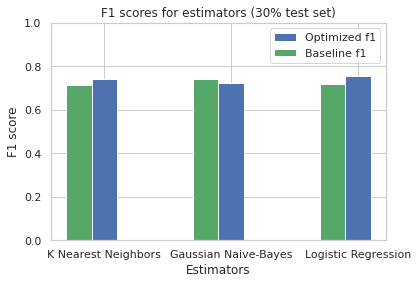

In [ ]:
xax = np.arange(len(optimized_f1))
ax = plt.subplot(111)
ax.bar(xax, optimized_f1.values(), width=0.2, color='b', align='center')
ax.bar(xax-0.2, baseline_f1.values(), width=0.2, color='g', align='center')
ax.legend(('Optimized f1','Baseline f1'))
plt.xticks(xax, optimized_f1.keys())
plt.ylabel("F1 score")
plt.xlabel("Estimators")
plt.title("F1 scores for estimators (30% test set)")
ax.set_ylim([0, 1])
plt.show()

In [ ]:
print("Αρχικές επιδόσεις:", baseline_f1)
print("Επιδόσεις βελτιστοποιημένων ταξινομητών:", optimized_f1)
print("kNN train time {:.2f} ms".format(train_time_knn*1000))
print("kNN test time {:.2f} ms".format(test_time_knn*1000))
print("GNB train time {:.2f} ms".format(train_time_gnb*1000))
print("GNB test time {:.2f} ms".format(test_time_gnb*1000))
print("LR train time {:.2f} ms".format(train_time_lr*1000))
print("LR test time {:.2f} ms".format(test_time_lr*1000))

Αρχικές επιδόσεις: {'K Nearest Neighbors': 0.7142857142857142, 'Gaussian Naive-Bayes': 0.7419354838709677, 'Logistic Regression': 0.7187499999999999}
Επιδόσεις βελτιστοποιημένων ταξινομητών: {'K Nearest Neighbors': 0.7428571428571429, 'Gaussian Naive-Bayes': 0.7213114754098361, 'Logistic Regression': 0.7547169811320754}
kNN train time 24.52 ms
kNN test time 10.96 ms
GNB train time 15.63 ms
GNB test time 4.10 ms
LR train time 22.07 ms
LR test time 5.22 ms


| Classifier           | Best F1 score (training set) | F1 score (baseline) | F1 score (optimized) | Optimization time (sec) | Train time (ms) | Test time (ms) |
|----------------------|------------------------------|---------------------|----------------------|-------------------------|-----------------|----------------|
| K Nearest Neighbors  | 79.5%                        | 71.4%                 | 74.3%                | 31.12                   | 24.52           | 10.96          |
| Gaussian Naive-Bayes | 79.2%                        | 74.2%               | 72.1%                | 17.78                   | 15.63           | 4.10           |
| Logistic Regression  | 77.0%                        | 71.9%               | 75.5%                | 428.07                  | 22.07           | 5.22           |

Παρατηρούμε πως στους ταξινομητές kNN και LR έχουμε μία μικρή αύξηση της μετρικής f1 έναντι των out-of-the-box εκδόσεών τους, ενώ ο GNB χειροτερεύει την απόδοσή του. Ο χρόνος που καταλαμβάνει η βελτιστοποίηση στον LR είναι εξαιρετικά μεγαλύτερος από τους άλλους δύο ταξινομητές, τόσο λόγω του τρόπου που αυτός λειτουργεί, όσο και λόγω του μεγαλύτερου πλήθους παραμέτρων που λαμβάνει. Ο χρόνος train και test είναι αρκετά κοντά για όλους τους ταξινομητές, το οποίο οφείλεται στο μικρό μέγεθος του dataset. Η βελτίωση στο f1 score δεν δικαιολογεί τον χρόνο του optimization, αφού ο GNB πετυχαίνει 74.2% πριν το optimization, με την καλύτερη τιμή μετά από αυτό να την πετυχαίνουμε με τον LR με 75.5% με optimization που διαρκεί 428 sec. Τέλος, με βάση τη μετρική f1 δεν έχουμε ξεκάθαρο νικητή, αφού τα αποτελέσματά τους βρίσκονται αρκετά κοντά μετά την βελτιστοποίηση.

##### Accuracy
Επαναλαμβάνουμε την ίδια ακριβώς διαδικασία χρησιμοποιώντας τη μετρική accuracy για την αξιολόγηση του μοντέλου.

In [ ]:
vthreshold = [0, 0.01, 0.1, 1, 10]
k = [1, 5, 10, 20, 25, 30, 35, 50]
n_components = [2, 4, 5, 7, 10]

scaler_knn = MinMaxScaler()
selector_knn = VarianceThreshold()
ros_knn = RandomOverSampler()
pca_knn = PCA()
knn = KNeighborsClassifier()

pipe_knn = Pipeline(
    steps=[
           ('selector', selector_knn),
           ('scaler', scaler_knn),
           ('sampler', ros_knn),
           ('pca', pca_knn),
           ('knn', knn)
           ], 
    memory='tmp')
estimator_knn_acc = GridSearchCV(pipe_knn, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  knn__n_neighbors=k,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='accuracy', 
                             n_jobs=-1)

start_time = time.time()
estimator_knn_acc.fit(X_train, y_train)
preds_knn = estimator_knn_acc.predict(X_test)

print("Συνολικός χρόνος fit και predict για kNN με μετρική accuracy: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_knn_acc.best_params_)
print("Το καλύτερο accuracy του ταξινομητή ήταν {:.3f} στο training set".format(estimator_knn_acc.best_score_))

Συνολικός χρόνος fit και predict για kNN με μετρική accuracy: 29.00 seconds
Βέλτιστες παράμετροι: {'knn__n_neighbors': 35, 'pca__n_components': 4, 'selector__threshold': 1}
Το καλύτερο accuracy του ταξινομητή ήταν 0.722 στο training set


In [ ]:
vthreshold = [0, 0.01, 0.1, 1, 10]
var_smoothing = [0, 1e-13, 1e-11, 1e-9, 1e-8]
n_components = [2, 4, 5, 7, 10]

scaler_gnb = StandardScaler()
selector_gnb = VarianceThreshold()
ros_gnb = RandomOverSampler()
pca_gnb = PCA()
gnb = GaussianNB()

pipe_gnb = Pipeline(
    steps=[
           ('selector', selector_gnb),
           ('scaler', scaler_gnb),
           ('sampler', ros_gnb),
           ('pca', pca_gnb),
           ('gnb', gnb)
           ], 
    memory='tmp')
estimator_gnb_acc = GridSearchCV(pipe_gnb, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  gnb__var_smoothing=var_smoothing,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='accuracy', 
                             n_jobs=-1)

start_time = time.time()
estimator_gnb_acc.fit(X_train, y_train)
preds_gnb = estimator_gnb_acc.predict(X_test)
print("Συνολικός χρόνος fit και predict για GNB με μετρική accuracy: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_gnb_acc.best_params_)
print("Το καλύτερο accuracy του ταξινομητή ήταν {:.3f} στο training set".format(estimator_gnb_acc.best_score_))

Συνολικός χρόνος fit και predict για GNB με μετρική accuracy: 16.74 seconds
Βέλτιστες παράμετροι: {'gnb__var_smoothing': 0, 'pca__n_components': 2, 'selector__threshold': 0.01}
Το καλύτερο accuracy του ταξινομητή ήταν 0.738 στο training set


In [ ]:
vthreshold = [0, 0.1, 1]
n_components = [2, 5, 7]
pen = ['l1', 'l2']
tol = [1e-8, 1e-6, 1e-4, 1e-3]
C = [0.5, 1.0, 1.5, 2.0, 2.5]
fit_intercept = [True, False]
max_iter = [50, 100, 200]

scaler_lr = StandardScaler()
selector_lr = VarianceThreshold()
ros_lr = RandomOverSampler()
pca_lr = PCA()
lr = LogisticRegression()

pipe_lr = Pipeline(
    steps=[
           ('selector', selector_lr),
           ('scaler', scaler_lr),
           ('sampler', ros_lr),
           ('pca', pca_lr),
           ('lr', lr)
           ], 
    memory='tmp')
estimator_lr_acc = GridSearchCV(pipe_lr, 
                             dict(
                                  selector__threshold=vthreshold,
                                  pca__n_components=n_components,
                                  lr__penalty=pen,
                                  lr__tol=tol,
                                  lr__C=C,
                                  lr__fit_intercept=fit_intercept,
                                  lr__max_iter=max_iter,
                                  lr__solver=['liblinear']
                                  ), 
                             cv=10, 
                             scoring='accuracy', 
                             n_jobs=-1)

start_time = time.time()
estimator_lr_acc.fit(X_train, y_train)
preds_lr = estimator_lr_acc.predict(X_test)
print("Συνολικός χρόνος fit και predict για LR με μετρική accuracy: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_lr_acc.best_params_)
print("Το καλύτερο accuracy του ταξινομητή ήταν {:.3f} στο training set".format(estimator_lr_acc.best_score_))

Συνολικός χρόνος fit και predict για LR με μετρική accuracy: 292.20 seconds
Βέλτιστες παράμετροι: {'lr__C': 0.5, 'lr__fit_intercept': False, 'lr__max_iter': 50, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'lr__tol': 1e-08, 'pca__n_components': 2, 'selector__threshold': 1}
Το καλύτερο accuracy του ταξινομητή ήταν 0.705 στο training set


Για κάθε ταξινομητή επιλέγουμε το μοντέλο που είχε τις καλύτερες επιδόσεις στη διαδικασία του cross validation και το εκπαιδεύουμε σε ολόκληρο το training set. Ύστερα συγκρίνουμε τα αποτελέσματά του στο test set με εκείνα των out-of-the-box ταξινομητών.

In [ ]:
knn_best_accuracy = estimator_knn_acc.best_estimator_
gnb_best_accuracy = estimator_gnb_acc.best_estimator_
lr_best_accuracy = estimator_lr_acc.best_estimator_

start_train_time_knn = time.time()
knn_best_accuracy.fit(X_train, y_train)
train_time_knn = time.time() - start_train_time_knn
start_test_time_knn = time.time()
knn_f1 = f1_score(y_test, knn_best_accuracy.predict(X_test))
test_time_knn = time.time() - start_test_time_knn

start_train_time_gnb = time.time()
gnb_best_accuracy.fit(X_train, y_train)
train_time_gnb = time.time() - start_train_time_gnb
start_test_time_gnb = time.time()
gnb_f1 = f1_score(y_test, gnb_best_accuracy.predict(X_test))
test_time_gnb = time.time() - start_test_time_gnb

start_train_time_lr = time.time()
lr_best_accuracy.fit(X_train, y_train)
train_time_lr = time.time() - start_train_time_lr
start_test_time_lr = time.time()
lr_f1 = f1_score(y_test, lr_best_accuracy.predict(X_test))
test_time_lr = time.time() - start_test_time_lr

optimized_acc = {}
optimized_acc["K Nearest Neighbors"] = knn_accuracy
optimized_acc["Gaussian Naive-Bayes"] = gnb_accuracy
optimized_acc["Logistic Regression"] = lr_accuracy

baseline_acc = {}
baseline_acc["K Nearest Neighbors"] = ootb_accuracy["K Nearest Neighbors"]
baseline_acc["Gaussian Naive-Bayes"] = ootb_accuracy["Gaussian Naive-Bayes"]
baseline_acc["Logistic Regression"] = ootb_accuracy["Logistic Regression"]

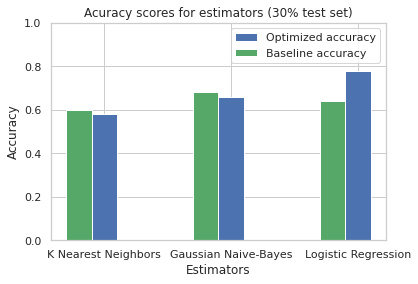

In [ ]:
xax = np.arange(len(optimized_acc))
ax = plt.subplot(111)
ax.bar(xax, optimized_acc.values(), width=0.2, color='b', align='center')
ax.bar(xax-0.2, baseline_acc.values(), width=0.2, color='g', align='center')
ax.legend(('Optimized accuracy','Baseline accuracy'))
plt.xticks(xax, optimized_acc.keys())
plt.ylabel("Accuracy")
plt.xlabel("Estimators")
plt.title("Acuracy scores for estimators (30% test set)")
ax.set_ylim([0, 1])
plt.show()

Από τη γραφική παράσταση φαίνεται πως ο μόνος ταξινομητής του οποίο η επίδοση βελτιώνεται είναι ο LR, του οποίου το accuracy βελτιώνεται περίπου κατά 0.15, ενώ οι άλλοι δύο ταξινομητές δεν βελτιώνουν την επίδοσή τους στο test set. 

In [ ]:
print("Αρχικές επιδόσεις:", baseline_acc)
print("Επιδόσεις βελτιστοποιημένων ταξινομητών:", optimized_acc)
print("kNN train time {:.2f} ms".format(train_time_knn*1000))
print("kNN test time {:.2f} ms".format(test_time_knn*1000))
print("GNB train time {:.2f} ms".format(train_time_gnb*1000))
print("GNB test time {:.2f} ms".format(test_time_gnb*1000))
print("LR train time {:.2f} ms".format(train_time_lr*1000))
print("LR test time {:.2f} ms".format(test_time_lr*1000))

Αρχικές επιδόσεις: {'K Nearest Neighbors': 0.6, 'Gaussian Naive-Bayes': 0.68, 'Logistic Regression': 0.64}
Επιδόσεις βελτιστοποιημένων ταξινομητών: {'K Nearest Neighbors': 0.58, 'Gaussian Naive-Bayes': 0.66, 'Logistic Regression': 0.78}
kNN train time 15.95 ms
kNN test time 6.36 ms
GNB train time 11.72 ms
GNB test time 3.57 ms
LR train time 11.25 ms
LR test time 3.47 ms


| Classifier           | Best accuracy (training set) | Accuracy (baseline) | Accuracy (optimized) | Optimization time (sec) | Train time (ms) | Test time (ms) |
|----------------------|------------------------------|---------------------|----------------------|-------------------------|-----------------|----------------|
| K Nearest Neighbors  | 72.2%                        | 60%                 | 58%                  | 29.00                   | 15.95           | 6.36           |
| Gaussian Naive-Bayes | 73.8%                        | 68%                 | 66%                  | 16.74                   | 11.72           | 3.57           |
| Logistic Regression  | 70.5%                        | 64%                 | 78%                  | 292.20                  | 11.25           | 3.47           |

Όπως και πριν ο χρόνος που απαιτεί ο LR στο στάδιο optimization είναι αρκετά μεγαλύτερος των άλλων δύο ταξινομητών. Ωστόσο στο συγκεκριμένο dataset το train time και το test time έχουν πολύ κοντινές τιμές για όλους τους ταξινομητές. Η βελτίωση στο accuracy του LR δικαιολογεί το χρόνο που σπαταλήσαμε στο optimization, αφού η επίδοσή του πηγαίνει από το 64% στο 78%, ενώ η δεύτερη καλύτερη επίδοση είναι του GNB στην baseline έκδοσή του με 68%. Επομένως, με βάση τη μετρική accuracy ο LR είναι ξεκάθαρος νικητής.

Παρακάτω δίνονται τα confusion matrices για τον καλύτερο (LR) και τον χειρότερο (kNN) ταξινομητή ως προς την ορθότητα.

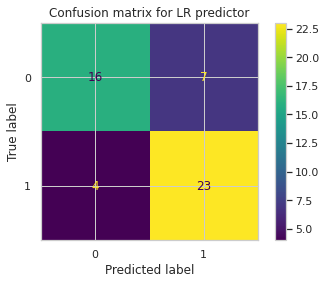

In [ ]:
cm = confusion_matrix(y_test, lr_best_accuracy.predict(X_test), labels=lr_best_accuracy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_best_accuracy.classes_)
disp.plot()
plt.title("Confusion matrix for LR predictor")
plt.show()

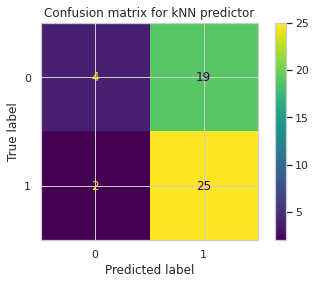

In [ ]:
cm = confusion_matrix(y_test, knn_best_accuracy.predict(X_test), labels=knn_best_accuracy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_best_accuracy.classes_)
disp.plot()
plt.title("Confusion matrix for kNN predictor")
plt.show()

Βλέπουμε πως ενώ ο LR κάνει missclassify 7 δείγματα από τη μία κατηγορία και 4 από την άλλη, ο kNN ουσιαστικά προβλέπει για όλα τα δείγματα την τιμή 1. Ο Logistic Regression ταξινομητής φαίνεται να δουλεύει καλύτερα στο πρόβλημα αυτό, καθώς τα χαρακτηριστικά των δεδομένων δεν ακολουθούν κανονική κατανομή με βάση την κλάση τους, ούτε βρίσκονται σχετικά συγκεντρωμένα στον πολυδιάστατο χώρο που βρίσκονται αλλά είναι διαχωρίσιμα. Έτσι, τα μοντέλα Gaussian Naive-Bayes και K Nearest Neighbors αντίστοιχα δεν επιτυγχάνουν υψηλές επιδόσεις ενώ το μοντέλο LR καταφέρνει να πετύχει υψηλά ποσοστά επιτυχίας.

## Μέρος 2: Kaggle dataset
Το kaggle dataset που μας αντιστοιχεί είναι το [kdd cyberattack](https://www.kaggle.com/slashtea/kdd-cyberattack). Το dataset αυτό περιέχει πληροφορίες σχετικά με connections σε ένα LAN της U.S. Air Force. Κάθε εγγραφή αποτελεί μία σύνδεση στο LAN, ενώ δίνεται επίσης ο χαρακτηρισμός 'normal' για τις κανονικές συνδέσεις ή το όνομα του είδους της επίθεσης για κάθε κακόβουλη σύνδεση στο δίκτυο. Σκοπός μας είναι να ξεχωρίσουμε τις κανονικές από τις κακόβουλες συνδέσεις.

In [2]:
!pip install ray[tune] tune-sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.pipeline import Pipeline
from ray.tune.sklearn import TuneGridSearchCV

     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 40 kB 5.4 MB/s 
     |████████████████████████████████| 119 kB 57.8 MB/s 
     |████████████████████████████████| 124 kB 79.9 MB/s 


### Εισαγωγή και επισκόπηση δεδομένων

Όπως και στο προηγούμενο μέρος φορτώνουμε το dataset στο notebook και κάνουμε μία επισκόπηση στα δεδομένα του.

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
path = '/content/drive/MyDrive/kaggle_datasets/kddcup.data_10_percent'
df = pd.read_csv(path, header=None)
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
         'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
         'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
         'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
         'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label']
print(df.shape)
df.head()

(494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
# get names of columns with categorical variables
s = (df.dtypes=='object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['protocol_type', 'service', 'flag', 'label']


  Δεν χρειάστηκε κάποια αλλαγή για να καταφέρουμε να διαβάσουμε το αρχείο στο notebook. Παρατηρούμε πως τα δεδομένα του dataset είναι πολύ περισσότερα από αυτά του προηγούμενου μέρους της άσκησης. Στο dataset δεν έχουμε τιμές που απουσιάζουν, ενώ βλέπουμε πως έχουμε συνολικά 42 στήλες, δηλαδή 41 χαρακτηριστικά και 1 label (η τελευταία στήλη). Από το [description](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names) του dataset και μία γρήγορη επισκόπηση του dataset βλέπουμε ότι τα χαρακτηριστικά protocol_type, service, flag και το label είναι τα μόνα που δεν λαμβάνουν αριθμητικές τιμές, ενώ τα χαρακτηριστικά land, logged_in, is_host_login και is_guest_login είναι τα μόνα αριθμητικά δεδομένα που δεν λαμβάνουν συνεχείς τιμές (1:yes/0:no).

In [6]:
# Επιβεβαιώνουμε πως δεν υπάρχουν κενά πεδία στο dataframe
print("Total missing values:", df.isnull().sum().sum())

Total missing values: 0


Μετονομάζουμε τις τιμές 'normal.' του label σε 0 και τις υπόλοιπες σε 1, ώστε το 1 να συμβολίζει κακόβουλη σύνδεση και το 0 κανονική σύνδεση.

In [7]:
df.loc[df.label == 'normal.', 'label'] = 0
df.loc[df.label != 0, 'label'] = 1
df['label'] = df['label'].astype(str).astype(int)

In [8]:
# count instances of each class
class1 = df.iloc[:,41].sum()
class0 = df.shape[0] - class1
print("Class 0 has {} samples which represents {:.1f}% of all samples".format
      (class0, class0/df.shape[0]*100))
print("Class 1 has {} samples which represents {:.1f}% of all samples".format
      (class1, class1/df.shape[0]*100))

Class 0 has 97278 samples which represents 19.7% of all samples
Class 1 has 396743 samples which represents 80.3% of all samples


Παρατηρούμε πως έχουμε σημαντικό βαθμό class imbalance, καθώς 8 στα 10 περίπου δείγματα αποτελούν κακόβουλη σύνδεση.

Βλέπουμε όλες τις τιμές που λαμβάνουν τα κατηγορικά δεδομένα με σκοπό να αποφασίσουμε τι είδους κωδικοποίηση να ακολουθήσουμε.

In [9]:
print("protocol_type values:")
print(df.loc[:,'protocol_type'].unique(), end="\n\n")
print("service values:")
print(df.loc[:,'service'].unique(), end="\n\n")
print("flag values")
print(df.loc[:,'flag'].unique())

protocol_type values:
['tcp' 'udp' 'icmp']

service values:
['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']

flag values
['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']


Τα δεδομένα του χαρακτηριστικού protocol_type λαμβάνουν μόνο 3 διαφορετικές τιμές, οπότε η κωδικοποίηση one-hot φαίνεται πως θα λειτουργήσει ικανοποιητικά για αυτό. Από την άλλη μεριά οι τιμές του χαρακτηριστικού service είναι πάρα πολλές και η one-hot κωδικοποίηση θα μεγαλώσει υπερβολικά τη διαστατικότητα του προβλήματος. Όμως για να μην αφαιρέσουμε την πληροφορία από το dataset μας επιλέγουμε να κάνουμε χρήση του ordinal encoding. Την ίδια απόφαση παίρνουμε και για το χαρακτηριστικό flag που εμφανίζει παρόμοια συμπεριφορά.

### Προετοιμασία δεδομένων
Στο στάδιο αυτό θα επεξεργαστούμε κατάλληλα τα δεδομένα ώστε να είναι κατάλληλα διαμορφωμένα για να δοθούν στα μοντέλα πρόβλεψης.



Αρχικά πριν από κάθε αλλαγή θα χωρίσουμε το dataset σε features και labels και ύστερα θα κάνουμε τον διαχωρισμό σε training και test set. Επιλέγουμε το test set να αποτελεί το 40% του συνολικού dataset διότι λόγω του μεγέθους του dataset έχουμε αρκετά δεδομένα στο υπόλοιπο 60% για να κάνουμε την εκπαίδευση και το αποτέλεσμα στο test set θα είναι πιο αντιπροσωπευτικό αν είναι μεγαλύτερο το μέγεθός του. Επιπλέον θα δημιουργήσουμε ένα υποσύνολο του training set για να χρησιμοποιήσουμε για ταχύτερη εκπαίδευση των μοντέλων πρόβλεψης καθώς το μεγάλο μέγεθος του dataset μας επιτρέπει κάτι τέτοιο.

Λόγω του μεγάλου χρόνου εκπαίδευσης του SVM, για την εκπαίδευσή του θα χρησιμοποιήσουμε ένα subset του training set.

In [10]:
# differentiate labels from features
X_df = df.iloc[:,:41].copy()
y_df = df.iloc[:,41].copy()

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.4)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_train, y_train, train_size=0.25)

Στο σημείο αυτό κάνουμε το encoding των κατηγορικών μεταβλητών όπως αναφέραμε παραπάνω. Για το ordinal encoding βρίσκουμε πόσες ξεχωριστές τιμές βρίσκονται στο training set και δίνουμε την τιμή n+1 στα δεδομένα που συναντάμε πρώτη φορά στο test set.

In [11]:
print('Total service values to encode')
print(len(X_train.loc[:,'service'].unique()), end='\n\n')
print('Total flag values to encode')
print(len(X_train.loc[:,'flag'].unique()))

Total service values to encode
66

Total flag values to encode
11


In [12]:
# first use ordinal encoder to handle 'service' and 'flag' features
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=66)
X_train[['service','flag']] = ord_encoder.fit_transform(X_train[['service','flag']])
X_test[['service','flag']] = ord_encoder.transform(X_test[['service','flag']])
X_train_red[['service','flag']] = ord_encoder.fit_transform(X_train_red[['service','flag']])

# now use one-hot encodine on 'protocol_type' feature
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols_train = pd.DataFrame(oh_encoder.fit_transform(X_train[['protocol_type']]))
oh_cols_test = pd.DataFrame(oh_encoder.transform(X_test[['protocol_type']]))
oh_cols_train_red = pd.DataFrame(oh_encoder.transform(X_train_red[['protocol_type']]))

oh_cols_train.index = X_train.index
oh_cols_test.index = X_test.index
oh_cols_train_red.index = X_train_red.index
num_X_train = X_train.drop(['protocol_type'], axis=1)
num_X_test = X_test.drop(['protocol_type'], axis=1)
num_X_train_red = X_train_red.drop(['protocol_type'], axis=1)
X_train = pd.concat([num_X_train, oh_cols_train], axis=1)
X_test = pd.concat([num_X_test, oh_cols_test], axis=1)
X_train_red = pd.concat([num_X_train_red, oh_cols_train_red], axis=1)

X_train.rename(columns={0: "protocol_type_0", 1: "protocol_type_1", 2: "protocol_type_2"}, inplace=True)
X_test.rename(columns={0: "protocol_type_0", 1: "protocol_type_1", 2: "protocol_type_2"}, inplace=True)
X_train_red.rename(columns={0: "protocol_type_0", 1: "protocol_type_1", 2: "protocol_type_2"}, inplace=True)

Ελέγχουμε πως έχουμε μόνο αριθμητικά δεδομένα στα datasets και πως δεν χάσαμε δείγματα.

In [13]:
X_train.head()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_0,protocol_type_1,protocol_type_2
301465,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
339900,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210453,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
226684,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
462713,0,45.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132,6,0.0,0.0,1.0,1.0,0.05,0.06,0.0,255,6,0.02,0.06,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [14]:
X_test.head()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_0,protocol_type_1,protocol_type_2
135770,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
230201,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
174747,0,14.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
382704,0,45.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,255,1,0.0,0.07,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
434279,0,14.0,9.0,520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
X_train_red.head()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_0,protocol_type_1,protocol_type_2
339645,0,13.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
402680,0,13.0,9.0,520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,478,478,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
256156,0,13.0,9.0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,510,510,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
116644,0,43.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,284,13,1.0,1.0,0.0,0.0,0.05,0.06,0.0,255,13,0.05,0.07,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
442561,0,13.0,9.0,520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.0,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
print(X_train_red.shape, X_train.shape)

(74103, 43) (296412, 43)


In [17]:
print(X_train.dtypes)
print(X_test.dtypes)
print(y_train.dtypes)
print(y_test.dtypes)

duration                         int64
service                        float64
flag                           float64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate              

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(296412, 43) (296412,)
(197609, 43) (197609,)


Τώρα πια τα δεδομένα είναι έτοιμα για χρήση στα μοντέλα πρόβλεψης.

### Ταξινόμηση
Οι ταξινομητές που θα μελετήσουμε σε αυτό το μέρος της εργασίας είναι οι:
* Multi-Layer Perceptron (MLP)
* Support Vector Machines (SVM)
Η μετρική που θα χρησιμοποιήσουμε θα είναι η recall, καθώς στο πρόβλημά μας απαιτούμε να έχουμε όσο το δυνατό λιγότερα false negatives (αν θεωρήσουμε positive την κακόβουλη σύνδεση), αφού ένα false negative σημαίνει πως μια επίθεση που δέχεται το δίκτυο θα τη θεωρήσουμε κανονική σύνδεση και θα της επιτρέψουμε να συμβεί.

#### Επίδοση out-of-the-box
Αρχικά θα δοκιμάσουμε να πραγματοποιήσουμε εκπαίδευση των δύο ταξινομητών χωρίς να αλλάξουμε τις default υπερπαραμέτρους τους. Αυτό το κάνουμε ώστε να έχουμε μια πιο ξεκάθαρη εικόνα της βελτίωσης της επίδοσης του ταξινομητή στο στάδιο της βελτιστοποίησης.

In [19]:
mlp = MLPClassifier()
svm = SVC()

mlp_ootb_fit_start = time.time()
mlp.fit(X_train, y_train)
mlp_ootb_fit_stop = time.time()
mlp_ootb_preds = mlp.predict(X_test)
mlp_ootb_pred_stop = time.time()

print("MLP recall:", recall_score(y_test, mlp_ootb_preds))
print("MLP fit time: {}".format(mlp_ootb_fit_stop - mlp_ootb_fit_start))

MLP recall: 0.9995145722877514
MLP fit time: 193.39664721488953


In [20]:
svm.fit(X_train_red, y_train_red)
svm_ootb_fit_stop = time.time()
svm_ootb_preds = svm.predict(X_test)
svm_ootb_pred_stop = time.time()

print("SVM recall:", recall_score(y_test, svm_ootb_preds))
print("SVM fit time: {}".format(svm_ootb_fit_stop - mlp_ootb_pred_stop))

SVM recall: 0.9986193679352932
SVM fit time: 151.1425313949585


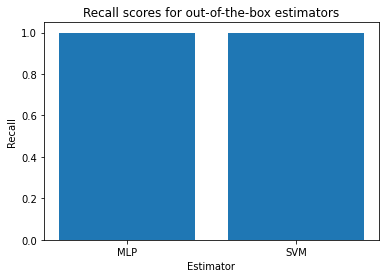

In [21]:
ootb_recall = {}
ootb_recall['MLP'] = recall_score(y_test, mlp_ootb_preds)
ootb_recall['SVM'] = recall_score(y_test, svm_ootb_preds)

plt.bar(range(len(ootb_recall)), list(ootb_recall.values()), align='center')
plt.xticks(range(len(ootb_recall)), list(ootb_recall.keys()))
plt.xlabel("Estimator")
plt.ylabel("Recall")
plt.title("Recall scores for out-of-the-box estimators")
plt.show()

Παρατηρούμε πως και οι δύο ταξινομητές επιτυγχάνουν πολύ καλές τιμές στο recall, με τον MLP να φτάνει το 99.95% και τον SVM το 99.86%. Η διαφορά των δύο ταξινομητών όμως φαίνεται στον χρόνο που χρειάζονται για να πραγματοποιήσουν τις προβλέψεις τους, καθώς ο SVM χρησιμοποιώντας μόλις το 1/4 του training set που χρησιμοποιεί ο MLP απαιτεί αντίστοιχο χρόνο για εκπαίδευσή του, ενώ χρειάζεται περίπου τον διπλάσιο χρόνο για να βγάλει τα αποτελέσματα που ζητάμε (predictions).

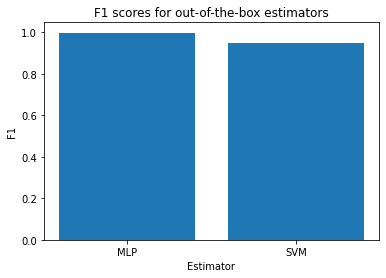

In [22]:
ootb_f1 = {}
ootb_f1['MLP'] = f1_score(y_test, mlp_ootb_preds)
ootb_f1['SVM'] = f1_score(y_test, svm_ootb_preds)

plt.bar(range(len(ootb_f1)), list(ootb_f1.values()), align='center')
plt.xticks(range(len(ootb_f1)), list(ootb_f1.keys()))
plt.xlabel("Estimator")
plt.ylabel("F1")
plt.title("F1 scores for out-of-the-box estimators")
plt.show()

Ελέγχουμε επίσης τα f1 scores των ταξινομητών για να βεβαιωθούμε πως δεν κατηγοριοποιούν όλα τα δείγματα στο test set στην κατηγορία 1, το οποίο θα έδινε πολύ καλό recall αλλά όχι και τις άλλες τιμές. Όμως βλέπουμε πως και οι δύο έχουν πολύ καλές τιμές F1, με τον MLP να είναι λίγο καλύτερος από τον SVM που σε συνδυασμό με την ταχύτερη εκπαίδευση και πρόβλεψη που μας χαρίζει τον καθιστά την καλύτερη επιλογή για out-of-the-box ταξινομητή.

In [23]:
fit_times = [(mlp_ootb_fit_stop-mlp_ootb_fit_start), (svm_ootb_fit_stop-mlp_ootb_pred_stop)]
pred_times = [mlp_ootb_pred_stop-mlp_ootb_fit_stop, svm_ootb_pred_stop-svm_ootb_fit_stop]
print("MLP train time:{:.1f} and predict time:{:.1f}".format(fit_times[0], pred_times[0]))
print("SVM train time:{:.1f} and predict time:{:.1f}".format(fit_times[1], pred_times[1]))

MLP train time:193.4 and predict time:0.8
SVM train time:151.1 and predict time:392.5


Το MLP βλέπουμε πως χρειάζεται πολύ λιγότερο χρόνο από τον ταξινομητή SVM τόσο στο training όσο και στο prediction των τιμών.

Οι επιδόσεις όλων των μοντέλων φαίνονται συνοπτικά στην ενότητα 'Παρουσίαση αποτελεσμάτων' σε πίνακα markdown.

#### Βελτιστοποίηση
Στο σημείο αυτό έχοντας ως baseline τα αποτελέσματα των out-of-the-box μοντέλων μπορούμε να προχωρήσουμε στο στάδιο της βελτιστοποίησης. Η βελτιστοποίηση θα επιτευχθεί μέσω των διαδικασιών:
* προεπεξεργασίας (scaling, PCA)
* ορισμού pipelines
* hyperparameter optimization με grid search με cross validation

Για την τρίτη διαδικασία θα κάνουμε χρήση της βιβλιοθήκης βελτιστοποίησης [Ray](https://docs.ray.io/en/latest/index.html) ώστε να βελτιώσουμε τον χρόνο που απαιτείται για τη διαδικασία.

Για την βελτιστοποίηση των μοντέλων με χρήση προεπεξεργασίας θα κάνουμε χρήση των συναρτήσεων VarianceThreshold(), StandardScaler()και PCA(). Η VarianceThreshold() θα αφαιρέσει τα χαρακτηριστικά τα οποία δεν εμφανίζουν διακύμανση, τα οποία δεν βοηθάνε στην κατηγοριοποίηση. Η StandardScaler() θα μετατρέψει την κατανομή των χαρακτηριστικών σε κανονική, την οποία και υποθέτουν οι ταξινομητές MLP και SVM. Τέλος, με την PCA() θα μειώσουμε τη διαστατικότητα του προβλήματος το οποίο συνήθως οδηγεί σε καλύτερα αποτελέσματα.

Ορίζουμε ένα pipeline που περιέχει τις παραπάνω συναρτήσεις και τον εκάστοτε ταξινομητή και με τη βοήθεια της TuneGridSearchCV() της βιβλιοθήκης Ray εκτελούμε cross validation για να βρούμε τις βέλτιστες υπερπαραμέτρους με σκοπό την αύξηση του recall. Η TuneGridSearchCV() εκτελεί 5-fold cross validation με την default τιμή της παραμέτρου cv.

In [27]:
N_COMPONENTS = [10, 20, 30]
ACTIVATION = ['relu']
ALPHA = [0.00001, 0.0001, 0.001]
TOL = [1e-5, 1e-4, 1e-3]
EARLY_STOPPING = [True]
N_ITER_NO_CHANGE = [5, 10]

scaler_mlp = StandardScaler()
selector_mlp = VarianceThreshold()
pca_mlp = PCA()
mlp = MLPClassifier()

pipe_mlp = Pipeline([
    ("threshold", scaler_mlp),
    ("scale", scaler_mlp),
    ("reduce_dim", pca_mlp),
    ("classify", mlp)
])

param_grid_mlp = [{
               "reduce_dim__n_components":N_COMPONENTS,
               "classify__activation":ACTIVATION,
               "classify__alpha":ALPHA,
               "classify__tol":TOL,
               "classify__early_stopping":EARLY_STOPPING,
               "classify__n_iter_no_change":N_ITER_NO_CHANGE
              }]

estimator_mlp = TuneGridSearchCV(pipe_mlp, param_grid=param_grid_mlp, scoring='recall')

fit_start_time_mlp = time.time()
estimator_mlp.fit(X_train, y_train)
fit_stop_time_mlp = time.time()

pred_start_time_mlp = time.time()
preds_mlp = estimator_mlp.predict(X_test)
pred_stop_time_mlp = time.time()
print("Συνολικός χρόνος fit για MLP: {:.1f} seconds".format(fit_stop_time_mlp - fit_start_time_mlp))
print("Συνολικός χρόνος predict για MLP: {:.1f} seconds".format(pred_stop_time_mlp - pred_start_time_mlp))

print("Βέλτιστες παράμετροι:",estimator_mlp.best_params_)
print("Το καλύτερο recall του ταξινομητή ήταν {:.4f} στο training set".format(estimator_mlp.best_score_))

best_mlp = estimator_mlp.best_estimator_
print(estimator_mlp.cv_results_)

/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:374: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "


Συνολικός χρόνος fit για MLP: 5252.6 seconds
Συνολικός χρόνος predict για MLP: 1.0 seconds
Βέλτιστες παράμετροι: {'classify__activation': 'relu', 'classify__alpha': 1e-05, 'classify__early_stopping': True, 'classify__n_iter_no_change': 10, 'classify__tol': 1e-05, 'reduce_dim__n_components': 30}
Το καλύτερο recall του ταξινομητή ήταν 0.9994 στο training set
{'params': [{'classify__activation': 'relu', 'classify__alpha': 1e-05, 'classify__early_stopping': True, 'classify__n_iter_no_change': 5, 'classify__tol': 1e-05, 'reduce_dim__n_components': 10}, {'classify__activation': 'relu', 'classify__alpha': 1e-05, 'classify__early_stopping': True, 'classify__n_iter_no_change': 5, 'classify__tol': 1e-05, 'reduce_dim__n_components': 20}, {'classify__activation': 'relu', 'classify__alpha': 1e-05, 'classify__early_stopping': True, 'classify__n_iter_no_change': 5, 'classify__tol': 1e-05, 'reduce_dim__n_components': 30}, {'classify__activation': 'relu', 'classify__alpha': 1e-05, 'classify__early_stop

Λόγω των πολλών συνδυασμών των παραμέτρων, του μεγάλου μεγέθους του dataset αλλά και του χρόνου που απαιτείτει για την εκπαίδευση ενός MLP ταξινομητή παρατηρούμε πως ο χρόνος βελτιστοποίησης είναι εξαιρετικά μεγάλος.

Για τον ταξινομητή SVM έχουμε λιγότερες παραμέτρους που πρέπει να ερευνήσουμε και τον εκπαιδεύουμε στο μικρό training set γιατί διαφορετικά ο χρόνος που απαιτεί η εκπαίδευσή του είναι απαγορευτικός.

In [29]:
N_COMPONENTS = [10, 20, 30]
C = [0.5, 1.0, 1.5]
TOL = [1e-3, 1e-2]

scaler_svm = StandardScaler()
selector_svm = VarianceThreshold()
pca_svm = PCA()
svm = SVC()

pipe_svm = Pipeline([
    ("threshold", scaler_svm),
    ("scale", scaler_svm),
    ("reduce_dim", pca_svm),
    ("classify", svm)
])

param_grid_svm = [{
               "reduce_dim__n_components":N_COMPONENTS,
               "classify__C":C,
               "classify__tol":TOL
              }]

estimator_svm = TuneGridSearchCV(pipe_svm, param_grid_svm, scoring='recall')

fit_start_time_svm = time.time()
estimator_svm.fit(X_train_red, y_train_red)
fit_stop_time_svm = time.time()

pred_start_time_svm = time.time()
preds_svm = estimator_svm.predict(X_test)
pred_stop_time_svm = time.time()
print("Συνολικός χρόνος fit για SVM: {:.1f} seconds".format(fit_stop_time_svm - fit_start_time_svm))
print("Συνολικός χρόνος predict για SVM: {:.1f} seconds".format(pred_stop_time_svm - pred_start_time_svm))

print("Βέλτιστες παράμετροι:",estimator_svm.best_params_)
print("Το καλύτερο recall του ταξινομητή ήταν {:.4f} στο training set".format(estimator_svm.best_score_))

best_svm = estimator_svm.best_estimator_
print(estimator_svm.cv_results_)

/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:374: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "


Συνολικός χρόνος fit για SVM: 357.6 seconds
Συνολικός χρόνος predict για SVM: 10.6 seconds
Βέλτιστες παράμετροι: {'classify__C': 1.5, 'classify__tol': 0.001, 'reduce_dim__n_components': 30}
Το καλύτερο recall του ταξινομητή ήταν 0.9990 στο training set
{'params': [{'classify__C': 0.5, 'classify__tol': 0.001, 'reduce_dim__n_components': 10}, {'classify__C': 0.5, 'classify__tol': 0.001, 'reduce_dim__n_components': 20}, {'classify__C': 0.5, 'classify__tol': 0.001, 'reduce_dim__n_components': 30}, {'classify__C': 0.5, 'classify__tol': 0.01, 'reduce_dim__n_components': 10}, {'classify__C': 0.5, 'classify__tol': 0.01, 'reduce_dim__n_components': 20}, {'classify__C': 0.5, 'classify__tol': 0.01, 'reduce_dim__n_components': 30}, {'classify__C': 1.0, 'classify__tol': 0.001, 'reduce_dim__n_components': 10}, {'classify__C': 1.0, 'classify__tol': 0.001, 'reduce_dim__n_components': 20}, {'classify__C': 1.0, 'classify__tol': 0.001, 'reduce_dim__n_components': 30}, {'classify__C': 1.0, 'classify__tol'

In [30]:
print(ootb_recall)
print(ootb_f1)

{'MLP': 0.9995145722877514, 'SVM': 0.9986193679352932}
{'MLP': 0.9975430439200561, 'SVM': 0.9478969068463475}


Διαλέγουμε τα καλύτερα μοντέλα όπως αυτά προέκυψαν από το cross validation και τα εκπαιδεύουμε στο training set. Στη συνέχεια εκτελούμε τις προβλέψεις για το test set ώστε να συγκρίνουμε την επίδοσή τους.

In [31]:
best_mlp_start_train = time.time()
best_mlp.fit(X_train, y_train)
best_mlp_stop_train = time.time()
fin_preds_mlp = best_mlp.predict(X_test)
best_mlp_stop_pred = time.time()

best_svm.fit(X_train_red, y_train_red)
best_svm_stop_train = time.time()
fin_preds_svm = best_svm.predict(X_test)
best_svm_stop_pred = time.time()

In [32]:
print("MLP fit time: {:.1f} and predict time: {:.1f}".
      format(best_mlp_stop_train-best_mlp_start_train, best_mlp_stop_pred-best_mlp_stop_train))
print("MLP recall score: {:.2f}%".format(recall_score(y_test, fin_preds_mlp)*100))
print("MLP f1 score: {:.2f}%".format(f1_score(y_test, fin_preds_mlp)*100))

print("SVM fit time: {:.1f} and predict time: {:.1f}".
      format(best_svm_stop_train-best_mlp_stop_pred, best_svm_stop_pred-best_svm_stop_train))
print("SVM recall score: {:.2f}%".format(recall_score(y_test, fin_preds_svm)*100))
print("SVM f1 score: {:.2f}%".format(f1_score(y_test, fin_preds_svm)*100))

MLP fit time: 63.9 and predict time: 0.6
MLP recall score: 99.96%
MLP f1 score: 99.96%
SVM fit time: 7.0 and predict time: 10.8
SVM recall score: 99.93%
SVM f1 score: 99.94%


Όπως ήταν αναμενόμενο οι επιδόσεις του MLP δεν βελτιώθηκαν ιδιαίτερα αφού το out-of-the-box μοντέλο ήταν ήδη κοντά στο 99% στις μετρικές recall και f1. Εκεί που παρατηρούμε βελτίωση είναι η επίδοση του SVM, η οποία βελτιώθηκε στη μετρική f1 score. Οι χρόνοι εκπαίδευσης των τελικών μοντέλων είναι αρκετά μικροί και για τους δύο ταξινομητές.

In [33]:
fin_recall = {}
fin_recall['MLP'] = recall_score(y_test, fin_preds_mlp)
fin_recall['SVM'] = recall_score(y_test, fin_preds_svm)

Δημιουργούμε γραφικές παραστάσεις για τις μετρικές recall η οποία και είναι η μετρική με την οποία αποφασίσαμε να συγκρίνουμε τα μοντέλα στο συγκεκριμένο dataset αλλά και f1 η οποία φανερώνει αν οι προβλέψεις του ταξινομητή είναι πράγματι σωστές.

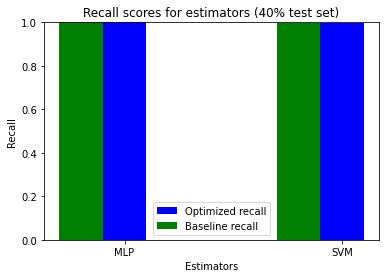

In [34]:
xax = np.arange(len(fin_recall))
ax = plt.subplot(111)
ax.bar(xax, fin_recall.values(), width=0.2, color='b', align='center')
ax.bar(xax-0.2, ootb_recall.values(), width=0.2, color='g', align='center')
ax.legend(('Optimized recall','Baseline recall'))
plt.xticks(xax, fin_recall.keys())
plt.ylabel("Recall")
plt.xlabel("Estimators")
plt.title("Recall scores for estimators (40% test set)")
ax.set_ylim([0, 1])
plt.show()

Όπως είπαμε και παραπάνω οι τιμές των δύο ταξινομητών ήταν ήδη πολύ μεγάλες για τις out-of-the-box εκδόσεις τους οπότε και δεν παρατηρείται διαφορά.

In [35]:
fin_f1 = {}
fin_f1['MLP'] = f1_score(y_test, fin_preds_mlp)
fin_f1['SVM'] = f1_score(y_test, fin_preds_svm)

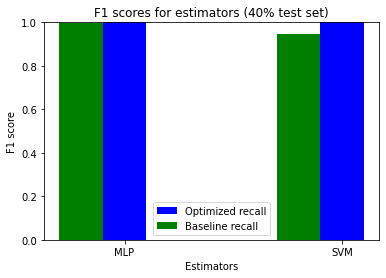

In [36]:
xax = np.arange(len(fin_f1))
ax = plt.subplot(111)
ax.bar(xax, fin_f1.values(), width=0.2, color='b', align='center')
ax.bar(xax-0.2, ootb_f1.values(), width=0.2, color='g', align='center')
ax.legend(('Optimized recall','Baseline recall'))
plt.xticks(xax, fin_f1.keys())
plt.ylabel("F1 score")
plt.xlabel("Estimators")
plt.title("F1 scores for estimators (40% test set)")
ax.set_ylim([0, 1])
plt.show()

Εδώ βλέπουμε τη βελτίωση της επίδοσης του μοντέλου SVM για τη μετρική f1 σε σύγκριση με το baseline μοντέλο.

### Παρουσίαση αποτελεσμάτων

Παρακάτω φαίνονται τα αποτελέσματα των πειραμάτων για τους δύο ταξινομητές.

| Classifier                                   | ootb train time | ootb predict time | ootb recall | ootb f1 | Optimization time | CV training best recall | Best model training time | Best model predict time | Best model recall | Best model f1 |
|----------------------------------------------|-----------------|-------------------|-------------|---------|-------------------|-----------------------------|--------------------------|-------------------------|-------------------|---------------|
| Multi-Layer Perceptron                       | 193.4 sec       | 0.8 sec           | 99.95%      | 99.75%  | 5252.6 sec        | 99.94%                      | 63.9 sec                 | 0.6 sec                 | 99.96%            | 99.96%        |
| SVM (25% of training set) | 151.1 sec       | 392.5 sec         | 99.86%      | 94.79%  | 357.6 sec         | 99.90%                      | 7.0 sec                  | 10.8 sec                | 99.93%            | 99.94%        |

Η απόδοση του ταξινομητή Multi Layer Perceptron είναι εξαιρετική στο συγκεκριμένο dataset χωρίς να απαιτείται καμία βελτιστοποίηση. Η εκπαίδευση του μοντέλου είναι αρκετά γρήγορη δεδομένου του μεγέθους του dataset.

Η απόδοση του ταξινομητή Support Vector Machine είναι καλή στο dataset αυτό χωρίς βελτιστοποίηση, ενώ μετά από τη βελτιστοποίηση πετυχαίνει τιμές αντίστοιχες με αυτές του MLP. Η εκπαίδευσή του είναι αρκετά αργή, όμως αν αντί για όλο το training set λάβει ένα υποσύνολο αυτού (τυχαίο ώστε να μην επηρεαστούν οι κατανομές των χαρακτηριστικών) πετυχαίνει καλή εκπαίδευση πολύ γρήγορα. Μάλιστα, το κομμάτι της βελτιστοποίησης ήταν πολύ ταχύτερο για το SVM από αυτό του MLP λόγω του μικρότερου training set και των λιγότερων υπερπαραμέτρων.

Το μοντέλο που προτείνουμε για το dataset είναι το Multi-Layer Perceptron καθώς χωρίς καμία βελτιστοποίηση και σε πολύ μικρό χρόνο πετυχαίνει εξαιρετικά αποτελέσματα σε όλες τις μετρικές.

Παρακάτω δίνονται και τα confusion matrices για τους δύο ταξινομητές. Υπενθυμίζουμε πως με label '1' συμβολίζονται οι κακόβουλες συνδέσεις και με '0' οι κανονικές.

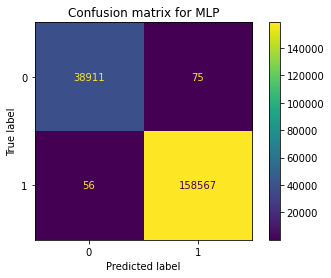

In [42]:
cm = confusion_matrix(y_test, fin_preds_mlp, labels=best_mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_mlp.classes_)
disp.plot()
plt.title("Confusion matrix for MLP")
plt.show()

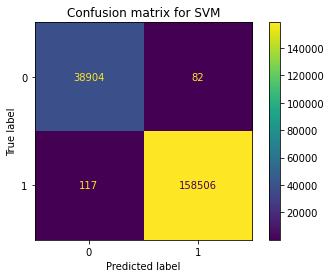

In [41]:
cm = confusion_matrix(y_test, fin_preds_svm, labels=best_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot()
plt.title("Confusion matrix for SVM")
plt.show()